[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/Regularization.ipynb)


# Regularization - Module 4.5

We saw that linear least squares can be seen as maximizing the likelihood $L(w) = \prod_{(x,y) \in \mathcal{D}} p(y|x, w)$, where $p(y|x;w)$ is a Gaussian with the mean $w^\top x$ and fixed variance. In logistic regression $p(y|x, w)$ is a Bernoulli distribution with mean $\sigma(w^\top x)$.
In both cases we find the maximum likelihood solution. Instead of maximizing the likelihood, we can find the maximum of the posterior over model parameters. That is we have the prior $p(w)$, as well as the likelihood $p(y| X, w) = \prod_{x,y \in \mathcal{D}} p(y|x, w)$. Using Bayes rule the posterior is *proportional* to the product of these two terms $p(w| X,y) \propto p(w) p(y|X, w)$. Maximizing the logarithm of the posterior becomes

\begin{equation}
\arg\max_w \log L(w) + \log p(w) = \arg\min_w  J(w) - \log p(w)
\end{equation}

where the cost function $J(w)$ (e.g., L2 or cross-entropy cost) is the negative of the log-likelihood.
We see that different choices of prior $p(w)$ simply add different types of penalty to our original cost function.
Choosing an isotropic Gaussian prior $p(w) = \prod_d \mathcal{N}(w_d|0, \frac{1}{\lambda})$ gives us L2 regularization:

\begin{equation}
\log p(w) = \sum_d \log \mathcal{N}(w_d|0, \frac{1}{\lambda}) = - \frac{\lambda}{2} \sum_d w_d^2 + \mathrm{constant}
\end{equation}

where the constant terms are additive terms that do not depend on $w$. 
Similarly, using **Laplace prior** $p(w) = \frac{1}{2 \beta} \prod_d \exp \left (\frac{|w|}{\beta} \right)$ gives L1 regularization:

\begin{equation}
\log p(w) = - {\lambda} \sum_d |w_d| + \mathrm{constant}
\end{equation}

where we set $\lambda = \frac{1}{\beta}$.

Below let's see the effect of this penalty term on the landscape of the regularized cost function in working with toy data.

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')
import itertools
from copy import deepcopy

import random
np.random.seed(1234)

# Linear regression and non-linear basis functions

In [2]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]                         #add a dimension for the features
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    #add bias by adding a constant feature of value 1
        #alternatively: self.w = np.linalg.inv(x.T @ x)@x.T@y
        self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference
        return self

    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w                             #predict the y values
        return yh


# Nonlinear basis functions
Consider the toy dataset below. It is obvious that our attempt to model $y$ as a linear function of $x$ would produce a bad fit.
Let's try!

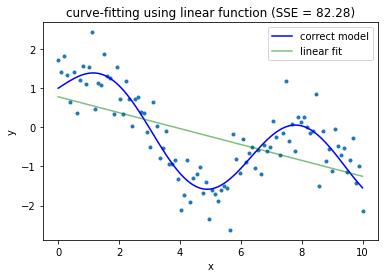

In [21]:
N = 100
x = np.linspace(0,10, N)
yt = np.sin(x) + np.cos(x**.5)                      # non-linear transformation
y = yt + .5*np.random.randn(N)                      # generate y using a non linear model and add noise
model = LinearRegression()
yh = model.fit(x,y).predict(x)
plt.plot(x, y, '.')
plt.plot(x, yt, 'b-', label='correct model')
plt.plot(x, yh, 'g-', alpha=.5, label='linear fit')

sse = np.square(yh - y).sum()
plt.title(f'curve-fitting using linear function (SSE = {sse:.2f})')

plt.xlabel('x')
plt.ylabel(r'y')
plt.legend()
# plt.show()
plt.savefig('sin.png', bbox_inches="tight", dpi=300)

In [22]:
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

One way around this is to create new features, and create a better fit using them. Right now we only have a single feature 'x' and we have a poor fit.
We can create new features out of existing ones. In this case, we create features that are Gaussian-like functions of 'x', where each feature has a different mean.
These are called non-linear bases, because each new feature is a non-linear function of the existing one.
Note that there are many other features that you can build to better fit this data. Below, we build ten such features with 10 different mean values.
By doing this our new design matrix (called `Phi` below) had 10 features (+1 intercept that is added in the `LinearRegression` class).
Below, let's plot these non-linear bases.

[ 0.  5. 10.]


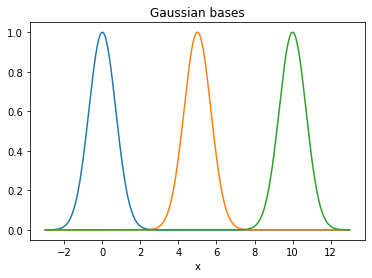

In [23]:
## plot Gaussian basis for larger range than x data

x_tended = np.linspace(-3,13,1000)

D=3
gaussian = lambda x,mu,sigma: np.exp(-((x-mu)/sigma)**2)          #non-linear feature function
mu = np.linspace(0,10,D)                                          #different mean values for the non-linear features
phi = gaussian(x_tended[:,None], mu[None,:],1)                           #gives a new set of features of the existing data

for d in range(D):
    plt.plot(x_tended, phi[:,d], '-')
    
plt.xlabel('x')
plt.title('Gaussian bases')
# plt.show()
plt.savefig('gaussian_basis.png', bbox_inches="tight", dpi=300)

print(mu)

[ 0.  5. 10.]


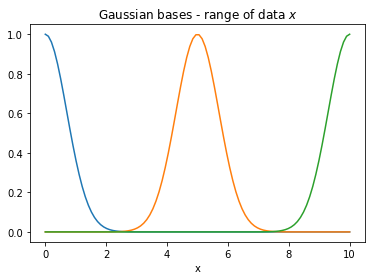

In [24]:
## plot Gaussian basis for range of x data

D=3

gaussian = lambda x,mu,sigma: np.exp(-((x-mu)/sigma)**2)          #non-linear feature function
mu = np.linspace(0,10,D)                                          #different mean values for the non-linear features
phi = gaussian(x[:,None], mu[None,:],1)                           #gives a new set of features of the existing data
                          
for d in range(D):
    plt.plot(x, phi[:,d], '-')
plt.xlabel('x')
plt.title('Gaussian bases - range of data $x$')
# plt.show()
plt.savefig('gaussian_basis.png', bbox_inches="tight", dpi=300)

print(mu)

Now we predict `y` using `phi` as input features rather than `x`:

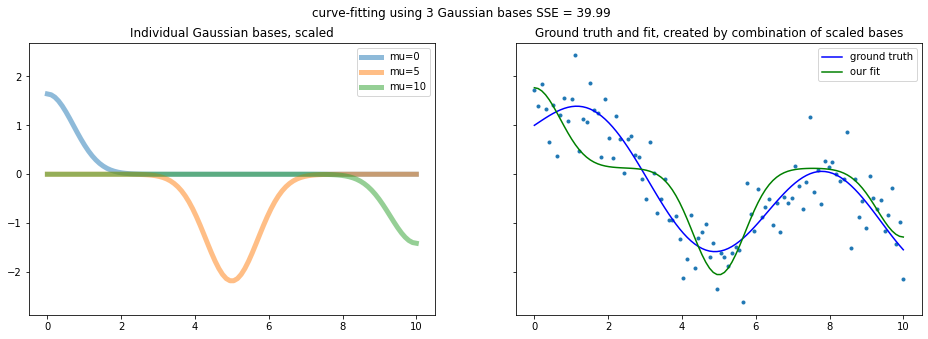

In [28]:
model = LinearRegression()
yh = model.fit(phi,y).predict(phi)

fig, ax = plt.subplots(1,2,figsize=[16.,5.], sharex=True, sharey=True)

for d in range(D):
    ax[0].plot(x, model.w[d]*phi[:,d], '-', alpha=.5, label='mu={}'.format(int(mu[d])), linewidth=5)
ax[0].legend()
ax[0].set_title('Individual Gaussian bases, scaled')

ax[1].plot(x, y, '.')
ax[1].plot(x, yt, 'b-', label='ground truth')
ax[1].plot(x, yh, 'g-', label='our fit')
ax[1].legend()
ax[1].set_title('Ground truth and fit, created by combination of scaled bases')

sse = np.square(yh - y).sum()
plt.suptitle(f'curve-fitting using {D} Gaussian bases SSE = {sse:.2f}')

plt.savefig(f'{D}_gaussian_bases_fit.png', bbox_inches="tight", dpi=300)

Let's try increase the bases function to 5, 10, 50, and 200.

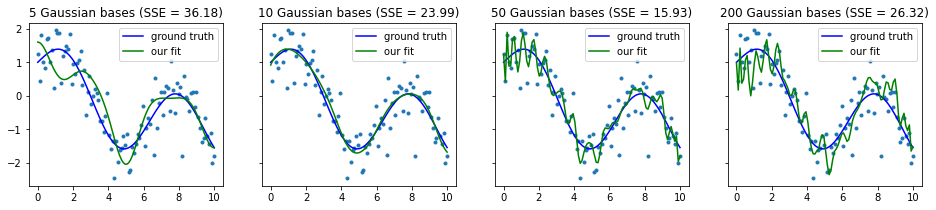

In [8]:
weight_list = []

fig, ax = plt.subplots(1,4,figsize=(16, 3), sharex=True, sharey=True)
for d, D in enumerate([5,10,50,200]):

    mu = np.linspace(0,10,D)                                          #different mean values for the non-linear features
    phi = gaussian(x[:,None], mu[None,:],1)                           #gives a new set of features of the existing data

    yh = model.fit(phi,y).predict(phi)

    weight_list.append(model.w) # store the model weights

    ax[d].plot(x, y, '.')
    ax[d].plot(x, yt, 'b-', label='ground truth')
    ax[d].plot(x, yh, 'g-', label='our fit')
    ax[d].legend()

    sse = np.square(yh - y).sum()
    ax[d].set_title(f'{D} Gaussian bases (SSE = {sse:.2f})')

    plt.savefig(f'{D}_gaussian_bases_fit.png', bbox_inches="tight", dpi=300)

Plot learned weights of linear regression models based on different number of Gaussian bases

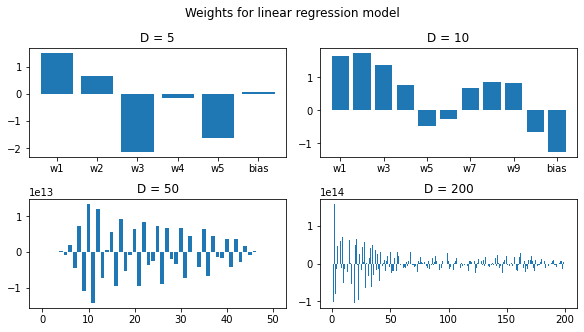

In [9]:
_, axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(8, 4.5), sharey=False)

axes[0,0].bar([i for i in range(len(weight_list[0]))], weight_list[0].tolist()); axes[0,0].set_title('D = 5')
axes[0,0].set_xticklabels(labels=['w'+str(d) for d in range(len(weight_list[0]))] + list(['bias']))

axes[0,1].bar([i for i in range(len(weight_list[1]))], weight_list[1].tolist()); axes[0,1].set_title('D = 10')
axes[0,1].set_xticklabels(labels=['w'+str((2*d)-1) for d in range(len(weight_list[1])//2+1)] + list(['bias']))

axes[1,0].bar([i for i in range(len(weight_list[2]))], weight_list[2].tolist()); axes[1,0].set_title('D = 50')
axes[1,1].bar([i for i in range(len(weight_list[3]))], weight_list[3].tolist()); axes[1,1].set_title('D = 200')

plt.suptitle('Weights for linear regression model')
plt.savefig('gaussian_bases_weights.png', bbox_inches="tight", dpi=300)

# Ridge regression

Let's create a toy data:

In [10]:
N = 20
x = np.random.rand(N) * 10
y = -4*x + 10 + 2*np.random.randn(N)

Visualize the regularized **cost function** 

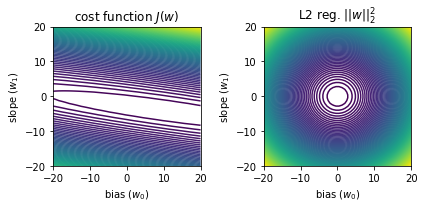

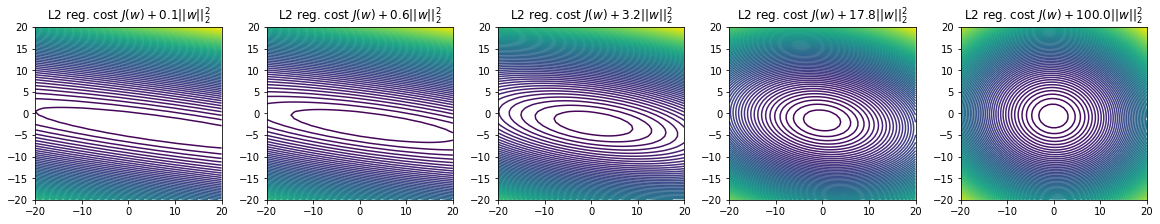

In [11]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
l2_penalty = lambda w: np.dot(w,w)/2
l1_penalty = lambda w: np.sum(np.abs(w))
cost_plus_l2 = lambda w: cost(w) + 5*l2_penalty(w)

_, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(6, 3))

plot_contour(cost, [-20,20], [-20,20], 50, axes[0])
axes[0].set_title(r'cost function $J(w)$')
axes[0].set_xlabel('bias ($w_0$)'); axes[0].set_ylabel('slope ($w_1$)')

plot_contour(l2_penalty, [-20,20], [-20,20], 50, axes[1])
axes[1].set_title(r'L2 reg. $||w||_2^2$')
axes[1].set_xlabel('bias ($w_0$)'); axes[1].set_ylabel('slope ($w_1$)')

plt.tight_layout()
plt.savefig('l2_contour_plots.png', bbox_inches="tight", dpi=300)
plt.show()

## create interpolation
lambdas = np.logspace(-1,2,5)
_, axes = plt.subplots(ncols=len(lambdas), nrows=1, constrained_layout=True, figsize=(16, 3))
for li,l in enumerate(lambdas):
  cost_plus_l2 = lambda w: cost(w) + l*l2_penalty(w)
  plot_contour(cost_plus_l2, [-20,20], [-20,20], 50, axes[li])
  axes[li].set_title(r'L2 reg. cost $J(w) + {:.1f} ||w||_2^2$'.format(l))
plt.show()

Let's use the `GradientDescent` and `LinearRegression` classes from the previous lecture. The only update we have made is in using `l2_reg` which sets the regularization coefficient $\lambda$ for L2 regularization. This information is used when calculating the gradient to perform weight decay. Note that a good practice is to *avoid penalizing the bias* $w_0$. Here, for the sake of visualization we penalize the bias as well.

In [12]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []
            
    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)
            w = w - self.learning_rate * grad
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w
    
class RidgeRegression:
    def __init__(self, add_bias=True, l2_reg=0):
        self.add_bias = add_bias
        self.l2_reg = l2_reg
        pass
            
    def fit(self, x, y, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        def gradient(x, y, w):
            yh =  x @ w 
            N, D = x.shape
            grad = .5*np.dot(yh - y, x)/N
            grad += self.l2_reg* w
            return grad
        w0 = np.array([3,-10]) # weights initialization 
        self.w = optimizer.run(gradient, x, y, w0)
        return self

    def fit_closedform(self, x, y):
        if x.ndim == 1:
            x = x[:, None]                         #add a dimension for the features

        N = x.shape[0]

        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    #add bias by adding a constant feature of value 1

        D = x.shape[1]
        if self.l2_reg==0:
            self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference
        else:
            self.w = np.linalg.inv(x.T @ x + self.l2_reg * np.identity(D)) @ x.T @ y

        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

Now let's visualize the landscape of regularized cost function for different amounts of regularization and see the effect of regularization on gradient descent.

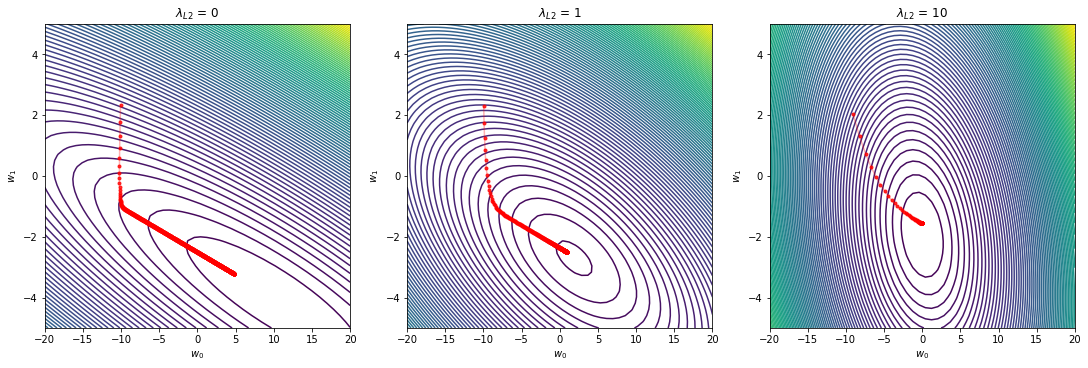

In [13]:
cost = lambda w, reg: .5*np.mean((w[0] + w[1]*x - y)**2) + reg*np.dot(w,w)/2
reg_list = [0, 1, 10]

## loop through different L2 regularization values
fig, axes = plt.subplots(ncols=len(reg_list), nrows=1, constrained_layout=True, figsize=(15, 5))
for i, reg_coef in enumerate(reg_list):
    ## instantiate and fit model
    optimizer = GradientDescent(learning_rate=.01, max_iters=1000, record_history=True)
    model = RidgeRegression(optimizer, l2_reg=reg_coef)
    model.fit(x,y, optimizer)

    ## update position within loss landscape
    current_cost = lambda w: cost(w, reg_coef)
    plot_contour(current_cost, [-20,20], [-5,5], 50, axes[i])
    w_hist = np.vstack(optimizer.w_history)# T x 2

    ## plot
    axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
    axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(r'$\lambda_{L2}$ = ' + str(reg_coef))
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-5,5])
plt.show()

The plots show that L2 regularization helps with the convergence of gradient descent.

# Fitting Gaussian bases using ridge regression

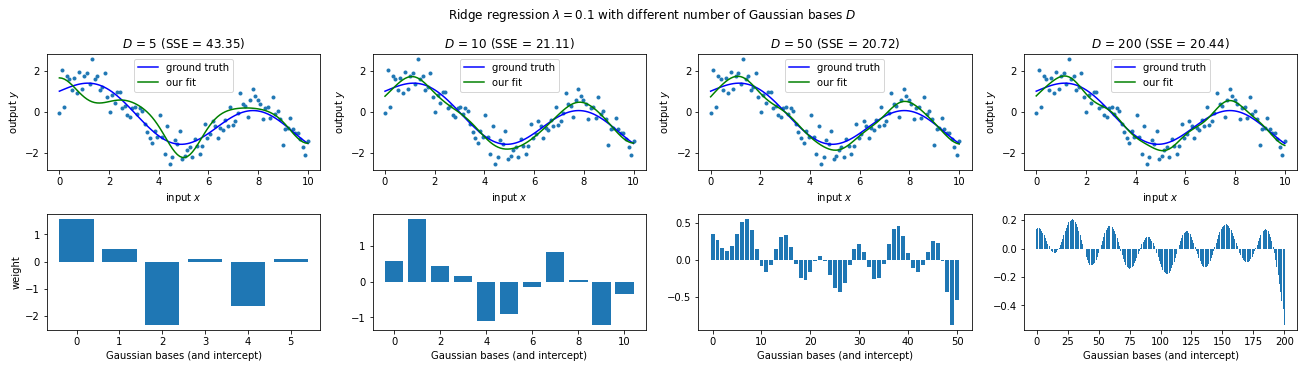

In [14]:
N = 100
x = np.linspace(0,10, N)
yt = np.sin(x) + np.cos(x**.5)
y = yt + .5*np.random.randn(N)                      #generate y using a non linear model and add noise

weight_list = []

optimizer = GradientDescent(learning_rate=.01, max_iters=50, record_history=False)

_, axes = plt.subplots(ncols=4, nrows=2, constrained_layout=True, figsize=(18, 5))
for d, D in enumerate([5, 10, 50, 200]):

    model = RidgeRegression(l2_reg=0.1)
    mu = np.linspace(0,10,D)                                          #different mean values for the non-linear features
    phi = gaussian(x[:,None], mu[None,:],1)                           #gives a new set of features of the existing data

    yh = model.fit_closedform(phi,y).predict(phi)

    weight_list.append(model.w) # store the model weights

    axes[0,d].plot(x, y, '.')
    axes[0,d].plot(x, yt, 'b-', label='ground truth')
    axes[0,d].plot(x, yh, 'g-', label='our fit')
    axes[0,d].legend()
    axes[0,d].set(xlabel='input $x$', ylabel='output $y$')

    sse = np.square(yh - y).sum()
    plt.savefig(f'{D}_gaussian_bases_ridge.png', bbox_inches="tight", dpi=300)

    axes[1,d].bar([i for i in range(len(model.w))], model.w.tolist()); axes[0,d].set_title('$D$ = {} (SSE = {:.2f})'.format(D,sse))
    axes[1,d].set(xlabel='Gaussian bases (and intercept)')

axes[1,0].set_ylabel('weight')
plt.suptitle('Ridge regression $\lambda=0.1$ with different number of Gaussian bases $D$')
plt.savefig('gaussian_bases_weights_ridge.png', bbox_inches="tight", dpi=300)

Text(0.5, 0.98, 'Ridge regression $D=200$ with different regularization values $\\lambda$')

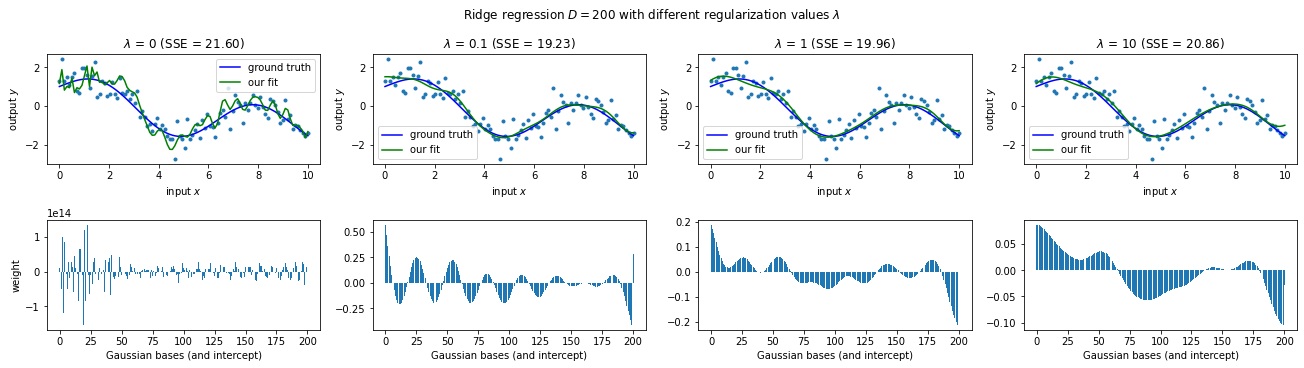

In [15]:
N = 100
x = np.linspace(0,10, N)
yt = np.sin(x) + np.cos(x**.5)
y = yt + .5*np.random.randn(N)                      #generate y using a non linear model and add noise

D = 200
mu = np.linspace(0,10,D)                                          #different mean values for the non-linear features
phi = gaussian(x[:,None], mu[None,:],1) 

weight_list = []

optimizer = GradientDescent(learning_rate=.01, max_iters=50, record_history=False)

_, axes = plt.subplots(ncols=4, nrows=2, constrained_layout=True, figsize=(18, 5))
for l, l2 in enumerate([0, 0.1, 1, 10]):

    model = RidgeRegression(l2_reg=l2)                          #gives a new set of features of the existing data

    yh = model.fit_closedform(phi,y).predict(phi)

    weight_list.append(model.w) # store the model weights

    axes[0,l].plot(x, y, '.')
    axes[0,l].plot(x, yt, 'b-', label='ground truth')
    axes[0,l].plot(x, yh, 'g-', label='our fit')
    axes[0,l].legend()
    axes[0,l].set(xlabel='input $x$', ylabel='output $y$')

    sse = np.square(yh - y).sum()

    axes[1,l].bar([i for i in range(len(model.w))], model.w.tolist()); axes[0,l].set_title('$\lambda$ = {} (SSE = {:.2f})'.format(l2,sse))
    axes[1,l].set(xlabel='Gaussian bases (and intercept)')

axes[1,0].set_ylabel('weight')
plt.suptitle('Ridge regression $D={}$ with different regularization values $\lambda$'.format(D))

# LASSO regression

In [16]:
class LassoRegression:
    def __init__(self, add_bias=True, spare_bias=True, l1_reg=0):
        self.add_bias = add_bias
        self.spare_bias = spare_bias
        self.l1_reg = l1_reg
        pass

    def soft_thresh(self, x, y, d):
        ## copy weights and set w_d to 0
        self.w_no_d = self.w.copy()
        self.w_no_d[d] = 0

        ## compute quantities needed for soft-thresholding
        x_no_d = x.copy()
        x_no_d[:,d] = 0
        yh_no_d = x_no_d@self.w_no_d
        x_d  = x[:,d]
        soft_thresh_arg = x_d.T @ (y - yh_no_d)
        sign = np.sign(soft_thresh_arg)

        ## spare bias/intercept parameter from L1 regularization
        if (self.add_bias and self.spare_bias and d==x.shape[1]):
            l1_reg = 0
        else:
            l1_reg = deepcopy(self.l1_reg)

        ## perform soft-thresholding
        soft_thresh_out = np.max( np.abs(soft_thresh_arg) - l1_reg , 0 )
        soft_thresh_out = sign * soft_thresh_out
        return soft_thresh_out, x_d

    def lasso_loss(self, x, y):
        regression_loss = 0.5 * (y - x@self.w).T @ (y - x@self.w) # standard regression loss
        l1_loss = self.l1_reg * np.abs(self.w).sum()              # contribution of L1 loss
        return regression_loss + l1_loss                          # full L1 loss
            
    def fit(self, x, y, max_iter=int(1e5), eps=1e-6, track_history=False):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])

        N,D = x.shape
        self.w = np.zeros(D)
        self.loss = self.lasso_loss(x, y)

        if track_history:
          self.w_history = [self.w.copy()]

        for i in range(max_iter):
          w_i = np.zeros(D)
          for d in range(D):
              soft_thresh_out, x_d = self.soft_thresh(x, y, d)  # soft-thresholding
              self.w[d] = soft_thresh_out / np.sum(x_d**2)      # re-adjust w_d

          if track_history:
            self.w_history.append(self.w.copy())

          ## verify whether loss is stabilized
          loss = self.lasso_loss(x, y)
          if np.abs(loss - self.loss) < eps:
              print('Training loss stabilized at iteration {}'.format(i))
              break
          else:
              self.loss = deepcopy(loss)

        if i == (max_iter-1):
          print('Training stopped at maximum iterations of {}'.format(max_iter))
        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

Fit LASSO regression model with different regularization parameter values $\lambda_{L1}$

Training loss stabilized at iteration 21
Training loss stabilized at iteration 50
Training stopped at maximum iterations of 1000
Training stopped at maximum iterations of 1000


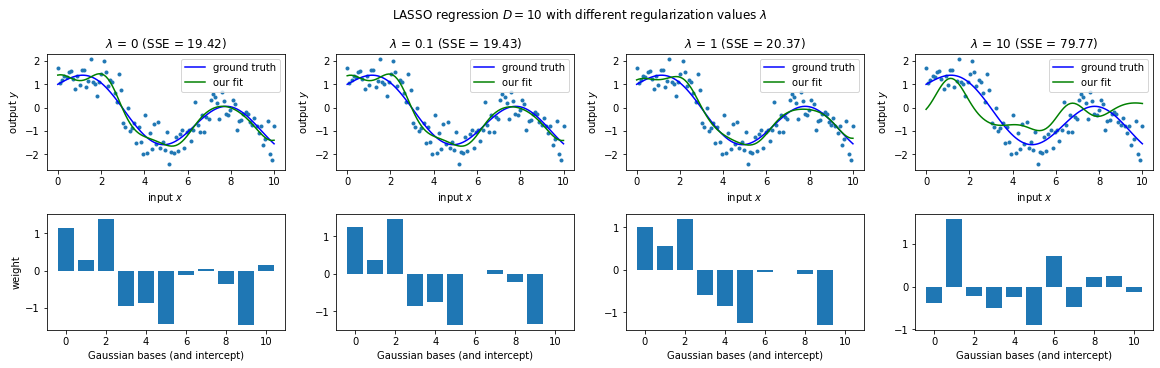

In [17]:
N = 100
x = np.linspace(0,10, N)
yt = np.sin(x) + np.cos(x**.5)
y = yt + .5*np.random.randn(N)                      #generate y using a non linear model and add noise

D = 10
mu = np.linspace(0,10,D)                                          #different mean values for the non-linear features
phi = gaussian(x[:,None], mu[None,:],1) 

weight_list = []

_, axes = plt.subplots(ncols=4, nrows=2, constrained_layout=True, figsize=(16, 5))
for l, l1 in enumerate([0, 0.1, 1, 10]):

    model = LassoRegression(l1_reg=l1)
    mu = np.linspace(0,10,D)                                          #different mean values for the non-linear features
    phi = gaussian(x[:,None], mu[None,:],1)                            #gives a new set of features of the existing data

    yh = model.fit(phi, y, max_iter=int(1e3), eps=1e-4).predict(phi)

    weight_list.append(model.w) # store the model weights

    axes[0,l].plot(x, y, '.')
    axes[0,l].plot(x, yt, 'b-', label='ground truth')
    axes[0,l].plot(x, yh, 'g-', label='our fit')
    axes[0,l].legend()
    axes[0,l].set(xlabel='input $x$', ylabel='output $y$')

    sse = np.square(yh - y).sum()

    axes[1,l].bar([i for i in range(len(model.w))], model.w.tolist()); axes[0,l].set_title('$\lambda$ = {} (SSE = {:.2f})'.format(l1,sse))
    axes[1,l].set(xlabel='Gaussian bases (and intercept)')

axes[1,0].set_ylabel('weight')
plt.suptitle('LASSO regression $D={}$ with different regularization values $\lambda$'.format(D))
plt.show()

Fit LASSO regression model with number of Gaussian bases $D$ and fixed $\lambda_{L1}=0.1$

Training loss stabilized at iteration 17
Training loss stabilized at iteration 19
Training loss stabilized at iteration 109
Training loss stabilized at iteration 154


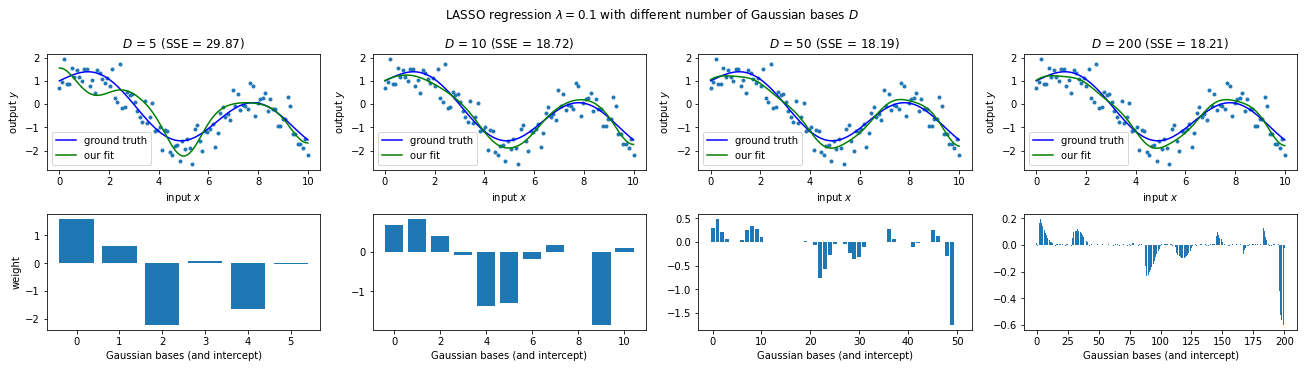

In [18]:
N = 100
x = np.linspace(0,10, N)
yt = np.sin(x) + np.cos(x**.5)
y = yt + .5*np.random.randn(N)                      #generate y using a non linear model and add noise

weight_list = []

_, axes = plt.subplots(ncols=4, nrows=2, constrained_layout=True, figsize=(18, 5))
for d, D in enumerate([5, 10, 50, 200]):

    model = LassoRegression(l1_reg=0.1)
    mu = np.linspace(0,10,D)                                          #different mean values for the non-linear features
    phi = gaussian(x[:,None], mu[None,:],1)                           #gives a new set of features of the existing data

    yh = model.fit(phi, y, max_iter=int(1e3), eps=1e-4).predict(phi)

    weight_list.append(model.w) # store the model weights

    axes[0,d].plot(x, y, '.')
    axes[0,d].plot(x, yt, 'b-', label='ground truth')
    axes[0,d].plot(x, yh, 'g-', label='our fit')
    axes[0,d].legend()
    axes[0,d].set(xlabel='input $x$', ylabel='output $y$')

    sse = np.square(yh - y).sum()

    axes[1,d].bar([i for i in range(len(model.w))], model.w.tolist()); axes[0,d].set_title('$D$ = {} (SSE = {:.2f})'.format(D,sse))
    axes[1,d].set(xlabel='Gaussian bases (and intercept)')

axes[1,0].set_ylabel('weight')
plt.suptitle('LASSO regression $\lambda=0.1$ with different number of Gaussian bases $D$')
plt.show()